Trial 10 Complete [00h 00m 54s]
val_accuracy: 0.6897974610328674

Best val_accuracy So Far: 0.6903600990772247
Total elapsed time: 02h 02m 18s
Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6611 - loss: 0.6129 - val_accuracy: 0.6703 - val_loss: 0.5963
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.5909 - val_accuracy: 0.6838 - val_loss: 0.5932
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6748 - loss: 0.5942 - val_accuracy: 0.6785 - val_loss: 0.5960
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6812 - loss: 0.5884 - val_accuracy: 0.6800 - val_loss: 0.5936
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6783 - loss: 0.5919 - val_accuracy: 0.6793 - val_loss: 0.5929
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6876 - loss: 0.5854 - val_accuracy: 0.6819 - val_loss: 0.5923
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6843 - loss: 0.5926 - v

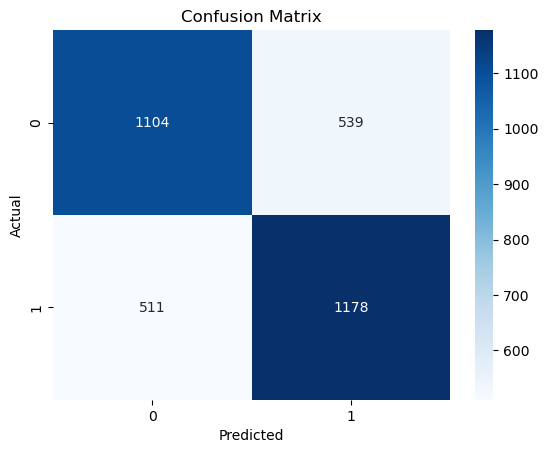

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

# Load the data
df = pd.read_csv("/home/swisnoski/nba_predictor_development/models/data/combined_data_2010-2023.csv")

# Replace win/loss indicators with binary values
df['TEAM_1_WIN/LOSS'] = df['TEAM_1_WIN/LOSS'].replace({100: 1, 0: 0})

# Drop rows where the target variable contains NaN
df = df.dropna(subset=['TEAM_1_WIN/LOSS'])

# Define features and target
X = df[[
        "TEAM_1_HOME/AWAY",
        "TEAM_1_DEF_PPP",
        "TEAM_1_TS%",
        "TEAM_1_eFG%",
        "TEAM_1_FG_PCT",
        "TEAM_1_DREB",
        "TEAM_1_AST",
        "TEAM_1_TOV",
        "TEAM_1_WIN_PCT",
        "TEAM_2_HOME/AWAY",
        "TEAM_2_DEF_PPP",
        "TEAM_2_TS%",
        "TEAM_2_eFG%",
        "TEAM_2_FG_PCT",
        "TEAM_2_DREB",
        "TEAM_2_AST",
        "TEAM_2_TOV",
        "TEAM_2_WIN_PCT",
    ]]  
y = df['TEAM_1_WIN/LOSS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the hypermodel
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units', min_value=16, max_value=128, step=16),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units', min_value=16, max_value=128, step=16),
        activation=hp.Choice('activation', values=['relu', 'tanh'])
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='nba_nn_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Best Neural Network accuracy: {accuracy * 100:.2f}%")

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Evaluate the model
print('Best Neural Network classification report:')
print(classification_report(y_test_true, y_pred))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test_true, y_pred)
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

